In [10]:
# Using uncalibrated airplane data, generate baseline and antenna calibrations for a given day
#
# Author: Brian Pitzel
# Date Created: 3 March 2025
# Date Modified: 3 March 2025

import numpy as np
import h5py 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import datetime
import csv
import glob
import pickle
import pymap3d as pm
from datetime import timezone
import warnings
import helpers.airplanes as ap
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib widget

vfromtimestamp = np.vectorize(datetime.datetime.fromtimestamp)
vutcfromtimestamp = np.vectorize(datetime.datetime.utcfromtimestamp)

In [20]:
def angular_mean_and_stdev(angles):
    """
    Calculates a circular mean and circular standard deviation of angles. Convert each angle into unit vector (cos(angle), sin(angle)),
    then sum the unit vectors and find the arctan of the resulting vector.
    Following https://rosettacode.org/wiki/Averages/Mean_angle and https://en.wikipedia.org/wiki/Directional_statistics#Standard_deviation.
    
    Parameters
    ----------
    angles: float ndarray (N,)
        the angles to average [rad]
    Returns
    -------
    average_angle:
        the average angle [rad]
    stdev:
        the standard deviation of the angles [rad]
    """

    # mean
    x = np.ma.sum(np.ma.cos(angles))
    y = np.ma.sum(np.ma.sin(angles))
    average_angle = np.ma.arctan2(y, x)

    # stdev
    n = np.count_nonzero(~np.isnan(angles))
    stdev = np.ma.sqrt(-2 * np.ma.log(np.ma.abs( (1/n) * np.ma.sum(np.ma.exp(1j * angles)) )))

    return average_angle, stdev


def angular_median(angles):
    """
    Calculates the angular median of a set of angles, assuming they are all within 0-360 degrees.
    If the sorted angles have a gap bigger than 180 degrees, the angle after that gap becomes
    the "first" angle and the angles are reordered starting from the first angle, taking the median
    of that newly ordered sequence.
    Parameters
    ----------
    angles: float ndarray (N,)
        the angles to average [rad]
    Returns
    -------
    average_angle:
        the average angle [rad]
    stdev:
        the standard deviation of the angles [rad]
    """
    # prep the arrays
    gap = np.deg2rad(50)
    angles_copy = np.ma.copy(angles)
    angles_copy = angles_copy[~np.isnan(angles_copy)]
    sorted_angles = np.sort(angles_copy)

    # find the consecutive differences in the angles
    diffs = np.ma.diff(sorted_angles)
    if np.ma.max(diffs) >= gap:
        new_first_idx = np.ma.argmax(diffs) + 1
    else:
        new_first_idx = 0

    
    # make the new set of indices based on the difference being greater than 180 or not
    idxs = []
    idxs.append(np.arange(new_first_idx, np.count_nonzero(~np.isnan(angles)))) #angles.shape[0]))
    idxs.append(np.arange(0, new_first_idx))
    idxs = np.hstack(idxs)

    # take the middle of indices as the median value
    median = sorted_angles[idxs[idxs.shape[0] // 2]]
    
    return median


def rle(inarray):
        """ run length encoding. Partial credit to R rle function. 
            Multi datatype arrays catered for including non Numpy
            returns: tuple (runlengths, startpositions, values) 

            example return:
            rle([True, True, True, False, True, False, False])
            Out[8]: 
            (array([3, 1, 1, 2]),
             array([0, 3, 4, 5]),
             array([ True, False,  True, False], dtype=bool))
            
            """
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]               # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)   # must include last element posi
            z = np.diff(np.append(-1, i))       # run lengths
            p = np.cumsum(np.append(0, z))[:-1] # positions
            return(z, p, ia[i])

In [11]:
# hard-coded magic numbers needed for the script

N_BASELINES = 45

# download aircraft data only if it falls within these lat/lon boundaries
# west, south, east, north
BOUNDS = (-109.375, 50.771, -106.0, 52.765) # old bounds
BOUNDS = (-109.375, 50.8, -106.4, 52.25) # new bounds, more constrained

# locations of the ICEBEAR receiver and transmitter
RX = (52.24393, -106.45025, 0)
TX = (50.893, -109.403, 0)
TX_RX_DISTANCE = 254 # km

# convert feet to meters
FT_TO_M = 1 / 3.281


# plotting stuff
fig_width_inches = 8#17
fig_height_inches = 5#10
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)

SMALL_SIZE = 20 #38
MEDIUM_SIZE = 25 #42
BIGGER_SIZE = 35 #56

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE//2)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [12]:
# inputs to the script:
# ymd - date of the day to calibrate on (will use data from all 24 hours unless otherwise specified)
# level1_files - UNCALIBRATED level 1 data (range correction applied, NO rx calibration applied)

year = 2024
month = 6
day = 20

# don't change these unless you want specific hours included/excluded
h = 0
n_hours = 24
level1_files = []
for i in range(n_hours):
    level1_files.append(f'/mnt/NAS/range-corrected-data/L1-no-cal/{year}/{month:02d}/{year}_{month:02d}_{day:02d}/ib3d_normal_01dB_1000ms_{year}_{month:02d}_{day:02d}_{(h+i):02d}_prelate_bakker.h5')


In [13]:
# unleash the beast

In [14]:
# first, find all of the airplane echoes in the level1_data.
# this allows us to pull airplane data at the proper times, instead of pulling ALL data from the entire day

t_start = datetime.datetime(year, month, day, 0, 0, 0, tzinfo=timezone.utc)
t_end = datetime.datetime(year, month, day, 23, 59, 59, tzinfo=timezone.utc)

airplane_xspectra, airplane_echo_time = ap.load_level1_airplane_xspectra(level1_files, t_start, t_end)
# now, for all of the timestamps at which there is airplane echoes, load in the airplane data
time_filter = np.ones(airplane_echo_time.shape, dtype=np.bool)
try:
    aircrafts_dbs = ap.load_airplane_data(f'aircrafts_dbs_{year:04d}-{month:02d}-{day:02d}.pckl')
except:
    aircrafts_dbs = ap.retrieve_airplane_data(airplane_echo_time, time_filter, BOUNDS)
    ap.save_aircrafts_dbs(aircrafts_dbs, f'{year:04d}-{month:02d}-{day:02d}')

2024-06-20 00:00:00+00:00 2024-06-20 23:59:59+00:00
Excepted [Errno 2] Unable to synchronously open file (unable to open file: name = '/mnt/NAS/range-corrected-data/L1-no-cal/2024/06/2024_06_20/ib3d_normal_01dB_1000ms_2024_06_20_00_prelate_bakker.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Continuing...
Excepted [Errno 2] Unable to synchronously open file (unable to open file: name = '/mnt/NAS/range-corrected-data/L1-no-cal/2024/06/2024_06_20/ib3d_normal_01dB_1000ms_2024_06_20_01_prelate_bakker.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Continuing...
Excepted [Errno 2] Unable to synchronously open file (unable to open file: name = '/mnt/NAS/range-corrected-data/L1-no-cal/2024/06/2024_06_20/ib3d_normal_01dB_1000ms_2024_06_20_02_prelate_bakker.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Continuing...
Excepted [Errno 2] Unable to synchronously open file (unable to op

FINISHED: : 93.5% [00:01, 92.6%/s]
DOWNLOAD: 114lines [00:00, 5.01klines/s]
FINISHED: : 64.5% [00:00, 70.9%/s]
DOWNLOAD: 5.00lines [00:00, 994lines/s]
FINISHED: : 67.7% [00:01, 67.0%/s]
DOWNLOAD: 63.0lines [00:00, 11.4klines/s]
FINISHED: : 100% [00:00, 492%/s]
DOWNLOAD: 20.0lines [00:00, 3.49klines/s]
FINISHED: : 100% [00:00, 491%/s]
DOWNLOAD: 135lines [00:00, 21.6klines/s]
FINISHED: : 100% [00:00, 493%/s]
DOWNLOAD: 80.0lines [00:00, 15.8klines/s]
FINISHED: : 96.8% [00:00, 239%/s]
DOWNLOAD: 5.00lines [00:00, 967lines/s]
FINISHED: : 100% [00:00, 493%/s]
DOWNLOAD: 4.00lines [00:00, 854lines/s]
FINISHED: : 100% [00:00, 493%/s]
DOWNLOAD: 5.00lines [00:00, 1.08klines/s]
FINISHED: : 90.3% [00:00, 149%/s]
DOWNLOAD: 6.00lines [00:00, 1.26klines/s]
FINISHED: : 100% [00:00, 491%/s]
DOWNLOAD: 165lines [00:00, 28.1klines/s]
FINISHED: : 65.5% [00:00, 108%/s]
DOWNLOAD: 16.0lines [00:00, 2.18klines/s]
FINISHED: : 100% [00:00, 329%/s] 
DOWNLOAD: 7.00lines [00:00, 1.51klines/s]
FINISHED: : 100% [00:00,

airplane 0
airplane 1
airplane 2
airplane 3
airplane 4
airplane 5
airplane 6
airplane 7
airplane 8
airplane 9
airplane 10
airplane 11
airplane 12
airplane 13
airplane 14
airplane 15
airplane 16
airplane 17
airplane 18
airplane 19
airplane 20
airplane 21
airplane 22
airplane 23
airplane 24
airplane 25
airplane 26
airplane 27
airplane 28
airplane 29
airplane 30
airplane 31
airplane 32
airplane 33
airplane 34
airplane 35
airplane 36
airplane 37
airplane 38
airplane 39
airplane 40
airplane 41
airplane 42
airplane 43
airplane 44
airplane 45
airplane 46
airplane 47
airplane 48
airplane 49
airplane 50
airplane 51
airplane 52
airplane 53
airplane 54
airplane 55
airplane 56
airplane 57
airplane 58
airplane 59
airplane 60
airplane 61
airplane 62
airplane 63
airplane 64
airplane 65
airplane 66
airplane 67
airplane 68
airplane 69
airplane 70
airplane 71
airplane 72
airplane 73
airplane 74
airplane 75
airplane 76
airplane 77
airplane 78
airplane 79
airplane 80
airplane 81
airplane 82
airplane 83
ai

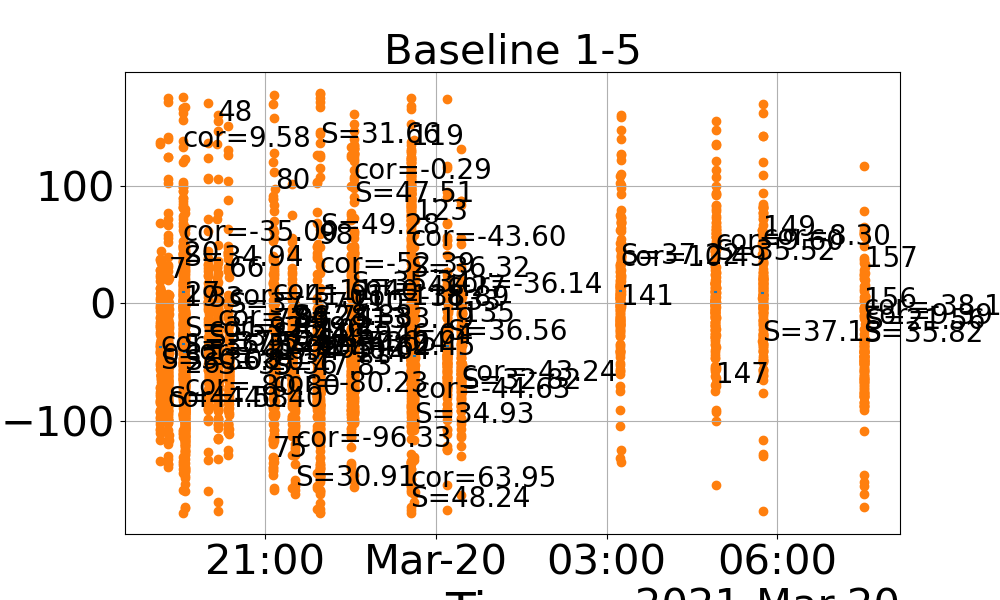

In [92]:
# now, progress through the airplanes, one at a time.
# calculate the expected phase of the airplane on each baseline, and compare it to the
# measured xspectra phase
# also make a sample plot to assist in picking out the good airplanes

# TODO: FIGURE OUT WHY THIS CHUNK IS SO MUCH SLOWER THAN THE NEXT CHUNK

baseline_to_plot = [1, 5]

fig, ax = plt.subplots()
fig.set_size_inches(fig_width_inches, fig_height_inches)
ax.set_ylabel('Baseline Phase [deg]')
ax.set_xlabel('Time ')
ax.set_title(f'Baseline {baseline_to_plot[0]}-{baseline_to_plot[1]}')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.grid()

# count the airplanes to know the size of the arrays we need
n_airplanes = 0
for db in aircrafts_dbs:
    # db is a database of every airplane in the timeframe.
    if db == None:
        continue
                
    # db[i].data.long/lat is the time series of data for one airplane (i)            
    for i in range(len(db)): # db[i] is a single airplane
        n_airplanes += 1

total_corrections = np.ndarray((n_airplanes, N_BASELINES), dtype=np.float32)
S_array = np.ndarray((n_airplanes, N_BASELINES), dtype=np.float32)
slopes_array = np.ndarray((n_airplanes, N_BASELINES), dtype=np.float32)


airplane_idx = 0
for db in aircrafts_dbs:
     # db is a database of every airplane in the timeframe.
    if db == None:
        continue
        
    # db[i].data.long/lat is the time series of data for one airplane (i)
    
    for i in range(len(db)): # db[i] is a single airplane in the timeframe
        print(f'airplane {airplane_idx}')
        # indexes in db contain multiple airplanes, so need to manually find the indices for this airplane
        start_idx = db[i].data.index[0]
        end_idx = db[i].data.index[-1]
            
        # using the indexes, find the start and end times of the airplane
        ti = db[i].data.timestamp[start_idx]
        tf = db[i].data.timestamp[end_idx]

        # we don't want to look at the short airplanes
        if end_idx - start_idx <= 6:
            total_corrections[airplane_idx, :] = np.nan
            S_array[airplane_idx, :] = np.nan
            slopes_array[airplane_idx, :] = np.nan
            airplane_idx += 1
            last_ti = ti
            last_tf = tf
            continue

        # or the short airplanes
        if np.mean(db[i].data.altitude * FT_TO_M) < 5000:
            total_corrections[airplane_idx, :] = np.nan
            S_array[airplane_idx, :] = np.nan
            slopes_array[airplane_idx, :] = np.nan
            airplane_idx += 1
            last_ti = ti
            last_tf = tf
            continue
        
        # from the airplane's geographic latitude/longitude/altitude, find the azimuth/elevation/altitude of the airplane from the receiver
        # this azimuth is measured EAST OF NORTH
        az, el, slant_range = ap.find_aer_from_receiver(db[i].data.latitude, db[i].data.longitude, db[i].data.altitude * FT_TO_M)
        # still east of north, but adjusted to be -180 to 180 instead of 0 to 360
        az = np.where(az > 180.0, az - 360.0, az)
        az = -az + 90 # convert to NORTH OF East angles

        # narrow the geographic bounds
        if np.any(db[i].data.latitude > 52.25) or np.any(db[i].data.longitude > -106.5) or np.any(db[i].data.longitude < -109.0) or np.all(el > 25) or np.all(az < 180) or np.all(az > 270):
            total_corrections[airplane_idx, :] = np.nan
            S_array[airplane_idx, :] = np.nan
            slopes_array[airplane_idx, :] = np.nan
            airplane_idx += 1
            last_ti = ti
            last_tf = tf
            continue
        
        this_airplane_db_time = db[i].data.timestamp[:] # .to_pydatetime().replace(tzinfo=timezone.utc)

        # progress through the baselines
        baseline = 0
        for antenna1 in range(10):
            for antenna2 in range(antenna1+1, 10):
                
                # now, we compare this airplane data to baseline data
                this_airplane_echo_indices = np.isin(airplane_echo_time, this_airplane_db_time)
                this_airplane_xspectra = airplane_xspectra[this_airplane_echo_indices, baseline]
                this_airplane_echo_time = airplane_echo_time[this_airplane_echo_indices]
        
                # when the data is DEAD, skip the plane
                if np.median(np.imag(this_airplane_xspectra)) == 0.0:
                    total_corrections[airplane_idx, baseline] = np.nan
                    S_array[airplane_idx, baseline] = np.nan
                    slopes_array[airplane_idx, baseline] = np.nan
                    baseline += 1
                    last_ti = ti
                    last_tf = tf
                    continue

                # need at least 5 data points, probably more
                if this_airplane_xspectra.shape[0] <= 5:
                    total_corrections[airplane_idx, baseline] = np.nan
                    S_array[airplane_idx, baseline] = np.nan
                    slopes_array[airplane_idx, baseline] = np.nan
                    baseline += 1
                    last_ti = ti
                    last_tf = tf
                    continue

                # ---- start the analysis ----

                # use the complex approach to finding the phase shift calibration
                expected_phase = ap.calculate_baseline_phase(antenna1, antenna2, az, el)
                expected_unit_vector = np.exp(1j * expected_phase)

                this_airplane_echo_timestamps = ap.datetime_to_seconds_since_epoch(this_airplane_echo_time)
                this_airplane_db_timestamps = ap.datetime_to_seconds_since_epoch(this_airplane_db_time.dt.to_pydatetime())

                phase_shift_series = []
                phase_shift_times = []

                # go one timestamp at a time
                for k in range(len(this_airplane_db_timestamps)):
                    visibility_indices = this_airplane_echo_timestamps == this_airplane_db_timestamps[k]

                    # do the complex multiplication
                    phase_shifts = np.rad2deg(np.angle(np.conjugate(expected_unit_vector[k]) * this_airplane_xspectra[visibility_indices]))
                    phase_shift_series.append(phase_shifts)
                    
                    # generate the time array needed to plot and do linear regression on this
                    for m in range(phase_shifts.shape[0]):
                        phase_shift_times.append(this_airplane_db_timestamps[k])

                # now we have the set of phase shifts for this baseline and airplane over time. we expect this to be constant over time
                phase_shift_series = np.hstack(phase_shift_series)
                phase_shift_times = np.hstack(phase_shift_times)
                
                # find the best fitting horizontal line (slope zero). the intercept (b_data) is the phase shift
                b_data, residuals = ap.linear_regression_with_known_slope2(phase_shift_times, phase_shift_series, m=0)
                S = np.sum(np.abs(phase_shift_series - b_data)) / phase_shift_series.shape[0] 
                R2 = 1 - residuals / (phase_shift_series.shape[0] * phase_shift_series.var())

                # do linear regression on the data (obtain non-zero slope)
                m, _ = np.polyfit(phase_shift_times, phase_shift_series, deg=1)

                # if S ( Standard Error of the Regression ) is too large, the data is very noisy and we'll ignore it
                if S > 50 or S < 1.0:
                    total_corrections[airplane_idx, baseline] = np.nan
                    S_array[airplane_idx, baseline] = np.nan
                    slopes_array[airplane_idx, baseline] = np.nan
                    baseline += 1
                    last_ti = ti
                    last_tf = tf
                    continue


                # we're almost there. we just need to check if this airplane matches the timestamp of the one before it.
                # if it does, we want to take the airplane with the minimum slope m and cancel out the other

                # this needs to be fixed. now it's going to meet the ti == last_ti ... condition 
                # as it proceeds across baselines, right? need to check that
                """
                if ti == last_ti and tf == last_tf:
                    if last_m >= m:
                        total_corrections[last_m_idx, baseline] = np.nan
                        S_array[last_m_idx, baseline] = np.nan
                        slopes_array[last_m_idx, baseline] = np.nan
                        last_m_idx = airplane_idx
                    else:
                        total_corrections[airplane_idx, baseline] = np.nan
                        S_array[airplane_idx, baseline] = np.nan
                        slopes_array[airplane_idx, baseline] = np.nan
                        baseline += 1
                        last_ti = ti
                        last_tf = tf
                        continue
                """
                last_ti = ti
                last_tf = tf
                last_m = m
                
                # if we reach this point, we're happy with the airplane. record the data instead of np.nans
                total_corrections[airplane_idx, baseline] = b_data[0]
                S_array[airplane_idx, baseline] = S
                slopes_array[airplane_idx, baseline] = m
                
                if antenna1 == baseline_to_plot[0] and antenna2 == baseline_to_plot[1]:
                    ax.scatter(vfromtimestamp(phase_shift_times), phase_shift_series, c='tab:orange')
                    ax.plot(vfromtimestamp([phase_shift_times[0], phase_shift_times[-1]]), [b_data, b_data], c='tab:blue') 
                    ax.annotate(f'{airplane_idx}', (vfromtimestamp(phase_shift_times)[-1], phase_shift_series[-1]), annotation_clip=False, fontsize=20)
                    #ax.annotate(f'R2={R2[0]:.2f}', (vfromtimestamp(phase_shift_times)[0], phase_shift_series[0]), annotation_clip=False, fontsize=20)
                    ax.annotate(f'S={S:.2f}', (vfromtimestamp(phase_shift_times)[0], phase_shift_series[0]), annotation_clip=False, fontsize=20)
                    ax.annotate(f'cor={b_data[0]:.2f}', (vfromtimestamp(phase_shift_times)[3], phase_shift_series[3]), annotation_clip=False, fontsize=20)

                baseline += 1
        airplane_idx += 1

"""


for antenna1 in range(10):
    for antenna2 in range(antenna1+1, 10):
        print(f'start baseline {baseline}')
        
        airplane_idx = 0
        ti = [-1] # for checking if multiple planes are at the same timestamps
        tf = [-1]
        for db in aircrafts_dbs:
            # db is a database of every airplane in the timeframe.
            if db == None:
                continue
                
            # db[i].data.long/lat is the time series of data for one airplane (i)
            
            for i in range(len(db)): # db[i] is a single airplane in the timeframe
                
                # indexes in db contain multiple airplanes, so need to manually find the indices for this airplane
                start_idx = db[i].data.index[0]
                end_idx = db[i].data.index[-1]
                    
                # using the indexes, find the start and end times of the airplane
                ti = db[i].data.timestamp[start_idx]
                tf = db[i].data.timestamp[end_idx]

                # we don't want to look at the short airplanes
                if end_idx - start_idx <= 6:
                    total_corrections[airplane_idx, baseline] = np.nan
                    S_array[airplane_idx, baseline] = np.nan
                    slopes_array[airplane_idx, baseline] = np.nan
                    airplane_idx += 1
                    last_ti = ti
                    last_tf = tf
                    continue

                # or the short airplanes
                if np.mean(db[i].data.altitude * FT_TO_M) < 5000:
                    total_corrections[airplane_idx, baseline] = np.nan
                    S_array[airplane_idx, baseline] = np.nan
                    slopes_array[airplane_idx, baseline] = np.nan
                    airplane_idx += 1
                    last_ti = ti
                    last_tf = tf
                    continue
                
                # from the airplane's geographic latitude/longitude/altitude, find the azimuth/elevation/altitude of the airplane from the receiver
                # this azimuth is measured EAST OF NORTH
                az, el, slant_range = ap.find_aer_from_receiver(db[i].data.latitude, db[i].data.longitude, db[i].data.altitude * FT_TO_M)
                # still east of north, but adjusted to be -180 to 180 instead of 0 to 360
                az = np.where(az > 180.0, az - 360.0, az)
                az = -az + 90 # convert to NORTH OF East angles
        
                # narrow the geographic bounds
                if np.any(db[i].data.latitude > 52.25) or np.any(db[i].data.longitude > -106.5) or np.any(db[i].data.longitude < -109.0) or np.all(el > 25) or np.all(az < 180) or np.all(az > 270):
                    total_corrections[airplane_idx, baseline] = np.nan
                    S_array[airplane_idx, baseline] = np.nan
                    slopes_array[airplane_idx, baseline] = np.nan
                    airplane_idx += 1
                    last_ti = ti
                    last_tf = tf
                    continue
                
                this_airplane_db_time = db[i].data.timestamp[:] # .to_pydatetime().replace(tzinfo=timezone.utc)
                
                # now, we compare this airplane data to baseline data
                this_airplane_echo_indices = np.isin(airplane_echo_time, this_airplane_db_time)
                this_airplane_xspectra = airplane_xspectra[this_airplane_echo_indices, baseline]
                this_airplane_echo_time = airplane_echo_time[this_airplane_echo_indices]
        
                # when the data is DEAD, skip the plane
                if np.median(np.imag(this_airplane_xspectra)) == 0.0:
                    total_corrections[airplane_idx, baseline] = np.nan
                    S_array[airplane_idx, baseline] = np.nan
                    slopes_array[airplane_idx, baseline] = np.nan
                    airplane_idx += 1
                    last_ti = ti
                    last_tf = tf
                    continue

                # need at least 5 data points, probably more
                if this_airplane_xspectra.shape[0] <= 5:
                    total_corrections[airplane_idx, baseline] = np.nan
                    S_array[airplane_idx, baseline] = np.nan
                    slopes_array[airplane_idx, baseline] = np.nan
                    airplane_idx += 1
                    last_ti = ti
                    last_tf = tf
                    continue

                # ---- start the analysis ----
                
                
                # use the complex approach to finding the phase shift calibration
                expected_phase = ap.calculate_baseline_phase(antenna1, antenna2, az, el)
                expected_unit_vector = np.exp(1j * expected_phase)

                this_airplane_echo_timestamps = ap.datetime_to_seconds_since_epoch(this_airplane_echo_time)
                this_airplane_db_timestamps = ap.datetime_to_seconds_since_epoch(this_airplane_db_time.dt.to_pydatetime())

                phase_shift_series = []
                phase_shift_times = []

                # go one timestamp at a time
                for k in range(len(this_airplane_db_timestamps)):
                    visibility_indices = this_airplane_echo_timestamps == this_airplane_db_timestamps[k]

                    # do the complex multiplication
                    phase_shifts = np.rad2deg(np.angle(np.conjugate(expected_unit_vector[k]) * this_airplane_xspectra[visibility_indices]))
                    phase_shift_series.append(phase_shifts)
                    
                    # generate the time array needed to plot and do linear regression on this
                    for m in range(phase_shifts.shape[0]):
                        phase_shift_times.append(this_airplane_db_timestamps[k])

                # now we have the set of phase shifts for this baseline and airplane over time. we expect this to be constant over time
                phase_shift_series = np.hstack(phase_shift_series)
                phase_shift_times = np.hstack(phase_shift_times)
                
                # find the best fitting horizontal line (slope zero). the intercept (b_data) is the phase shift
                b_data, residuals = ap.linear_regression_with_known_slope2(phase_shift_times, phase_shift_series, m=0)
                S = np.sum(np.abs(phase_shift_series - b_data)) / phase_shift_series.shape[0] 
                R2 = 1 - residuals / (phase_shift_series.shape[0] * phase_shift_series.var())

                # do linear regression on the data (obtain non-zero slope)
                m, _ = np.polyfit(phase_shift_times, phase_shift_series, deg=1)

                # if S ( Standard Error of the Regression ) is too large, the data is very noisy and we'll ignore it
                if S > 50 or S < 1.0:
                    total_corrections[airplane_idx, baseline] = np.nan
                    S_array[airplane_idx, baseline] = np.nan
                    slopes_array[airplane_idx, baseline] = np.nan
                    airplane_idx += 1
                    last_ti = ti
                    last_tf = tf
                    continue


                # we're almost there. we just need to check if this airplane matches the timestamp of the one before it.
                # if it does, we want to take the airplane with the minimum slope m and cancel out the other

                # TODO: this needs to be able to have the history of the last however many airplanes have the same time
                # if ti == last_ti and tf == last_tf:
                #     m_last = slopes_array[airplane_idx-1, baseline]
                #     if m_last >= m:
                #         total_corrections[airplane_idx-1, baseline] = np.nan
                #         S_array[airplane_idx-1, baseline] = np.nan
                #         slopes_array[airplane_idx-1, baseline] = np.nan
                #     else:
                        
                        
                        
                    # total_corrections[airplane_idx, baseline] = b_data[0]
                    # S_array[airplane_idx, baseline] = S
                    # slopes_array[airplane_idx, baseline] = m
                    
                last_ti = ti
                last_tf = tf
                

                
                # if we reach this point, we're happy with the airplane. record the data instead of np.nans
                total_corrections[airplane_idx, baseline] = b_data[0]
                S_array[airplane_idx, baseline] = S
                slopes_array[airplane_idx, baseline] = m
                
                if antenna1 == baseline_to_plot[0] and antenna2 == baseline_to_plot[1]:
                    ax.scatter(vfromtimestamp(phase_shift_times), phase_shift_series, c='tab:orange')
                    ax.plot(vfromtimestamp([phase_shift_times[0], phase_shift_times[-1]]), [b_data, b_data], c='tab:blue') 
                    ax.annotate(f'{airplane_idx}', (vfromtimestamp(phase_shift_times)[-1], phase_shift_series[-1]), annotation_clip=False, fontsize=20)
                    #ax.annotate(f'R2={R2[0]:.2f}', (vfromtimestamp(phase_shift_times)[0], phase_shift_series[0]), annotation_clip=False, fontsize=20)
                    ax.annotate(f'S={S:.2f}', (vfromtimestamp(phase_shift_times)[0], phase_shift_series[0]), annotation_clip=False, fontsize=20)
                    ax.annotate(f'cor={b_data[0]:.2f}', (vfromtimestamp(phase_shift_times)[3], phase_shift_series[3]), annotation_clip=False, fontsize=20)

                airplane_idx += 1
        baseline += 1    

"""                
plt.show(fig)


In [ ]:
# ______________------------------------_____________________

here, 0
here, 1
here, 2
here, 4
here, 5
here, 6
here, 7
here, 8
here, 13
here, 16
here, 18
here, 19

here, 20

here, 21

here, 22
here, 23
here, 24
here, 25
here, 26
here, 27
here, 48
here, 49
here, 50
here, 51
here, 52
here, 53
here, 54
here, 55
here, 56
here, 57
here, 59
here, 99

here, 100
here, 101
here, 102
here, 103
here, 105

here, 106

here, 107
here, 137
here, 138
here, 139
here, 140
here, 141
(44, 45)
(44,)
[False  True  True  True  True False  True  True False  True False  True
  True  True  True False  True  True  True  True False  True  True  True
  True False  True  True  True  True  True False  True  True  True  True
  True  True  True False  True  True  True  True]
[1 4 1 2 1 1 1 4 1 4 1 4 1 5 1 7 1 4]
[ 0  1  5  6  8  9 10 11 15 16 20 21 25 26 31 32 39 40]
[False  True False  True False  True False  True False  True False  True
 False  True False  True False  True]
0 5
5 8
8 10
10 15
15 20
20 25
25 31
31 39
39 44


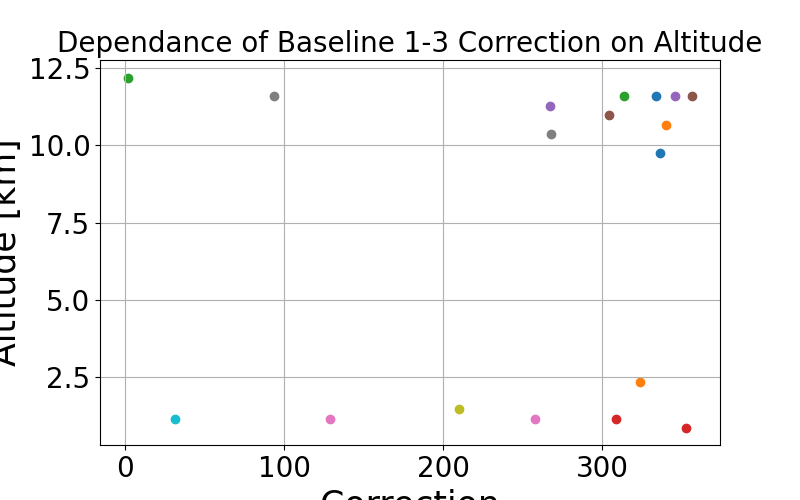

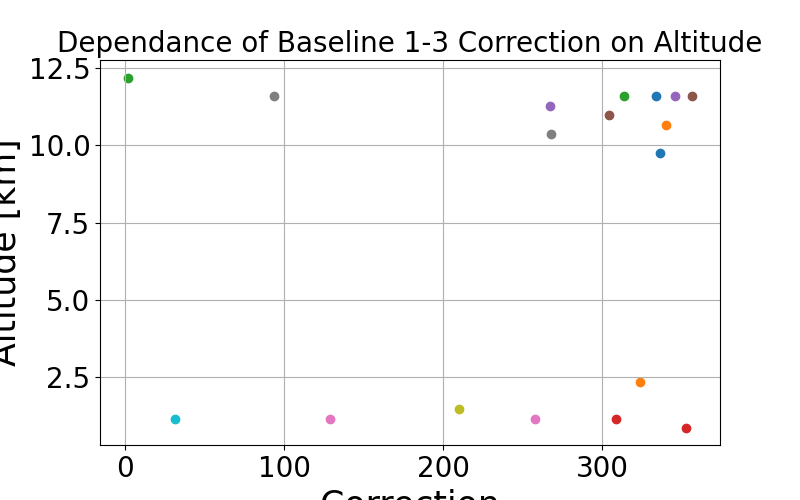

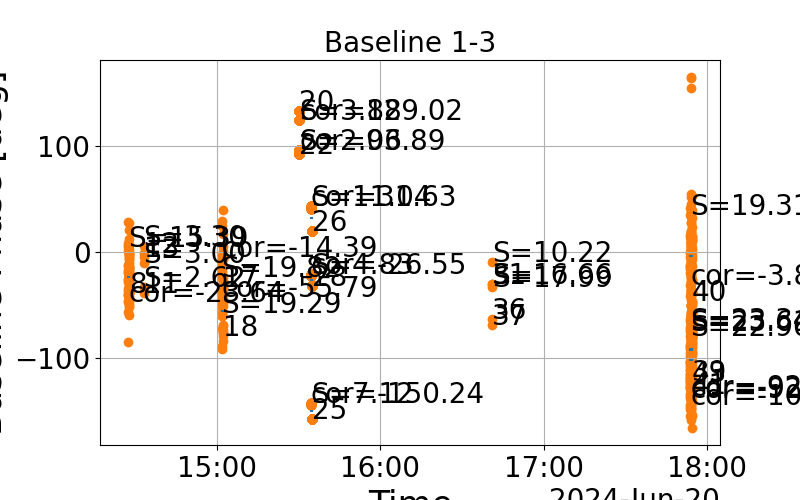

In [17]:
# now, progress through the airplanes, one at a time.
# calculate the expected phase of the airplane on each baseline, and compare it to the
# measured xspectra phase
# also make a sample plot to assist in picking out the good airplanes

#baseline_to_plot = [1, 5]
baseline_to_plot = [1, 3]
#baseline_to_plot = [0, 7]

fig, ax = plt.subplots()
fig.set_size_inches(fig_width_inches, fig_height_inches)
ax.set_ylabel('Baseline Phase [deg]')
ax.set_xlabel('Time')
ax.set_title(f'Baseline {baseline_to_plot[0]}-{baseline_to_plot[1]}')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.grid()

fig2, ax2 = plt.subplots()
fig2.set_size_inches(fig_width_inches, fig_height_inches)
ax2.set_ylabel('Altitude [km]')
ax2.set_xlabel('Correction')
ax2.set_title(f'Dependance of Baseline {baseline_to_plot[0]}-{baseline_to_plot[1]} Correction on Altitude')
ax2.grid()


total_corrections = []
total_phase_slopes = []

ti = [-1] # for checking if multiple planes are at the same timestamps
tf = [-1]
same_times = [] # any run of Trues in this list have the same timestamp as each other
last_ti = 0
last_tf = 0

airplane_idx = 0
label = 0
# ON THE FIRST RUN THROUGH, UNCOMMENT THIS LINE.
# ON THE SECOND RUN THROUGH, COMMENT THIS LINE AND FILL IN THE LIST AS NEEDED        
plane_indices = []

#plane_indices = [0,1,7,9,10,14,20,25,27,29,33,39,40,46,47,48] # 13/03/2021
#plane_indices = [1,3,9,12,16,34,53,67,106,109,123,127,132,139,141,143,150,152,182] # 12/12/2020
#plane_indices = [2,7,10,22,27,32,36,37,50,57,64] # 01/03/2021
#plane_indices = [66,95,105,119,132] # 20/03/2021
#plane_indices = [10,97,243,293,311,352,358,375] # 25/08/2021



for db in aircrafts_dbs:
    # db is a database of every airplane in the timeframe.
    if db == None:
        continue
        
    # db[i].data.long/lat is the time series of data for one airplane (i)
    
    for i in range(len(db)): # db[i] is a single airplane in the timeframe.
        # ON THE FIRST RUN THROUGH, UNCOMMENT THIS LINE.
        # ON THE SECOND RUN THROUGH, COMMENT THIS LINE.
        plane_indices.append(airplane_idx)

        if airplane_idx not in plane_indices:
            airplane_idx += 1
            continue
        
        # indexes in db continue multiple airplanes, so need to manually find the indices for this airplane
        start_idx = db[i].data.index[0]
        end_idx = db[i].data.index[-1]

        # we don't want to look at the short airplanes
        if end_idx - start_idx <= 6:
            airplane_idx += 1
            continue
            
        # using the indexes, find the start and end times of the airplane
        ti = db[i].data.timestamp[start_idx]
        #ti = ti.replace(tzinfo=None)
        tf = db[i].data.timestamp[end_idx]
        #tf = tf.replace(tzinfo=None)


        
        # from the airplane's geographic latitude/longitude/altitude, find the azimuth/elevation/altitude of the airplane from the receiver
        # this azimuth is measured EAST OF NORTH
        az, el, slant_range = ap.find_aer_from_receiver(db[i].data.latitude, db[i].data.longitude, db[i].data.altitude * FT_TO_M)
        # still east of north, but adjusted to be -180 to 180 instead of 0 to 360
        az = np.where(az > 180.0, az - 360.0, az)
        az = -az + 90 # convert to NORTH OF East angles

        #if np.mean(db[i].data.altitude * FT_TO_M) < 7000:
        #    airplane_idx += 1
        #    continue
        
        if np.any(db[i].data.latitude > 52.25) or np.any(db[i].data.longitude > -106.5) or np.any(db[i].data.longitude < -109.0) or np.all(el > 25) or np.all(az < 180) or np.all(az > 270):
            airplane_idx += 1
            continue
        
        this_airplane_db_time = db[i].data.timestamp[:] # .to_pydatetime().replace(tzinfo=timezone.utc)
        
        # now, we compare this airplane data to baseline data
        this_airplane_echo_indices = np.isin(airplane_echo_time, this_airplane_db_time)
        this_airplane_xspectra = airplane_xspectra[this_airplane_echo_indices, :]
        this_airplane_echo_time = airplane_echo_time[this_airplane_echo_indices]

        # when the data is DEAD, skip the plane
        if np.median(np.imag(this_airplane_xspectra)) == 0.0:
            airplane_idx += 1
            continue
        
        if ti == last_ti and tf == last_tf:
            same_times.append(True)
        else:
            same_times.append(False)

        last_ti = ti
        last_tf = tf
        
        corrections_this_airplane = [] # a full set of baseline corrections from a single airplane
        phase_slopes_this_airplane = [] # the slope of the line of best fit (not horizontal) of the phase data for this airplane
        
        baseline = 0
        print(f'here, {airplane_idx}')
        for antenna1 in range(10):
            for antenna2 in range(antenna1+1, 10):
                #"""
                # try something different: complex approach
                expected_phase = ap.calculate_baseline_phase(antenna1, antenna2, az, el)
                expected_unit_vector = np.exp(1j * expected_phase)

                this_airplane_echo_timestamps = ap.datetime_to_seconds_since_epoch(this_airplane_echo_time)
                this_airplane_db_timestamps = ap.datetime_to_seconds_since_epoch(this_airplane_db_time.dt.to_pydatetime())

                # for each timestamp TODO: double check this is working properly. looks like its just going off of a single value of expected phase currently, instead of progressing in time
                # with the data
                phase_shift_series = []
                phase_shift_times = []
                
                for k in range(len(this_airplane_db_timestamps)):
                    visibility_indices = this_airplane_echo_timestamps == this_airplane_db_timestamps[k]

                    # do the complex multiplication
                    phase_shifts = np.rad2deg(np.angle(np.conjugate(expected_unit_vector[k]) * this_airplane_xspectra[visibility_indices, baseline]))
                    phase_shift_series.append(phase_shifts)
                    
                    # generate the time array needed to plot this
                    for m in range(phase_shifts.shape[0]):
                        phase_shift_times.append(this_airplane_db_timestamps[k])

          
                phase_shift_series = np.hstack(phase_shift_series)
                phase_shift_times = np.hstack(phase_shift_times)
                
                # find the best fitting horizontal line (slope zero)
                b_data, residuals = ap.linear_regression_with_known_slope2(phase_shift_times, phase_shift_series, m=0)
                S = np.sum(np.abs(phase_shift_series - b_data)) / phase_shift_series.shape[0] 
                R2 = 1 - residuals / (phase_shift_series.shape[0] * phase_shift_series.var())

                # do linear regression on the data (obtain non-zero slope)
                m, _ = np.polyfit(phase_shift_times, phase_shift_series, deg=1)

                phase_slopes_this_airplane.append(m)
                
                #corrections_this_airplane.append(np.rad2deg(ap.angular_mean_and_stdev(np.deg2rad(phase_shift_series))[0]))
                #corrections_this_airplane.append(b_data[0])

                

                
                # need to find a way to make these magic numbers baseline dependent
                # median of current S values? ensures at least one value
                if S <= 35 and S >= 1.0:
                    corrections_this_airplane.append(b_data[0])
                    if antenna1 == baseline_to_plot[0] and antenna2 == baseline_to_plot[1]:
                        ax2.scatter(b_data[0]%360, np.mean(db[i].data.altitude * FT_TO_M)/1000)
                        
                        ax.scatter(vfromtimestamp(phase_shift_times), phase_shift_series, c='tab:orange')
                        ax.plot(vfromtimestamp([phase_shift_times[0], phase_shift_times[-1]]), [b_data, b_data], c='tab:blue') 
                        ax.annotate(f'{label}', (vfromtimestamp(phase_shift_times)[-1], phase_shift_series[-1]), annotation_clip=False, fontsize=20)
                        #ax.annotate(f'R2={R2[0]:.2f}', (vfromtimestamp(phase_shift_times)[0], phase_shift_series[0]), annotation_clip=False, fontsize=20)
                        ax.annotate(f'S={S:.2f}', (vfromtimestamp(phase_shift_times)[0], phase_shift_series[0]), annotation_clip=False, fontsize=20)
                        try:
                            ax.annotate(f'cor={b_data[0]:.2f}', (vfromtimestamp(phase_shift_times)[3], phase_shift_series[3]), annotation_clip=False, fontsize=20)
                        except:
                            print('')
                else:
                    corrections_this_airplane.append(np.nan)

                #print(corrections_this_airplane[-1])
                
                """
                # obtain the expected phase of the airplane on the baseline based on the airplane GPS
                expected_phase = ap.calculate_baseline_phase(antenna1, antenna2, az, el)
                expected_phase = np.rad2deg(expected_phase)

                # obtain the relevant baseline visibility
                vis_phase = np.rad2deg(np.angle(this_airplane_xspectra[:, baseline]))
                
                # unwrap the visibility phase
                tol = 45
                n_median = 3
                vis_phase_saved = vis_phase
                vis_phase = ap.unwrap_phase(vis_phase, tol=tol)
                
                #v1 = vis_phase
                # i mean, this isn't feasible. it has to be done for EVERY BASELINE
                #vis_phase = manually_adjust_phase(vis_phase, year, month, day, airplane_idx)
                #v2 = vis_phase
                #print(v1 == v2)
                
                # calculate a linear best fit for the expected airplane baseline phase 
                this_airplane_db_timestamps = ap.datetime_to_seconds_since_epoch(this_airplane_db_time.dt.to_pydatetime())
                m, b_plane = np.polyfit(this_airplane_db_timestamps, expected_phase, deg=1)
                
                # using the slope of that best fit, do least squares regression on the measured data
                # this will find the y-intercept that best matches the measured data to a line with the slope m
                this_airplane_echo_timestamps = ap.datetime_to_seconds_since_epoch(this_airplane_echo_time)
                b_data, residuals = ap.linear_regression_with_known_slope2(this_airplane_echo_timestamps, vis_phase, m)
                R2 = 1 - residuals / (vis_phase.shape[0] * vis_phase.var())

                # plot the best fit line for the predicted baseline phase
                x = np.array([this_airplane_db_timestamps[0], this_airplane_db_timestamps[-1]])
                y = m * x + b_plane
                y1 = y
                x = vfromtimestamp(x)
                #ax.plot(x, y, c='black')
                
                # plot the measured visibility phase and it's best fit line                
                #if np.all(vis_phase) != 0:

                x = np.array([this_airplane_echo_timestamps[0], this_airplane_echo_timestamps[-1]])
                y = m * x + b_data
                y2 = y
                correction = (y2-y1)[0]
                x = vfromtimestamp(x) # don't use vutcfromtimestamp here because the data is already in utc

                if antenna1 == baseline_to_plot[0] and antenna2 == baseline_to_plot[1]:
                    ax.plot(x, y-correction, c='tab:orange')
                    ax.scatter(vfromtimestamp(this_airplane_echo_timestamps), vis_phase_saved-correction, c='tab:blue')
                    ax.scatter(vfromtimestamp(this_airplane_echo_timestamps), vis_phase-correction, c='tab:orange')
                    ax.scatter(vfromtimestamp(this_airplane_db_timestamps), expected_phase, c='black')
                    ax.annotate(f'{airplane_idx}', (vfromtimestamp(this_airplane_db_timestamps)[0], expected_phase[0]), annotation_clip=False, fontsize=30)
                    ax.annotate(f'R2={R2[0]:.2f}', (vfromtimestamp(this_airplane_db_timestamps)[-1], expected_phase[-1]), annotation_clip=False, fontsize=20)

                # record the correction for this baseline
                corrections_this_airplane.append(correction)
                #"""
                baseline += 1

        corrections_this_airplane = np.array(corrections_this_airplane)
        total_corrections.append(corrections_this_airplane)

        phase_slopes_this_airplane = np.array(phase_slopes_this_airplane)
        total_phase_slopes.append(phase_slopes_this_airplane)
        
        airplane_idx += 1
        label += 1
        
total_corrections = np.array(total_corrections)
total_phase_slopes = np.array(total_phase_slopes)
same_times = np.array(same_times)
print(total_phase_slopes.shape)
print(same_times.shape)
# use the phase slopes and the same_times list to find the best airplane at each time when there is multiple airplanes
lengths, start_pos, value = rle(same_times)
print(same_times)
print(lengths)
print(start_pos)
print(value)
for i in range(value.shape[0]):
    if i == 0: # first entry here is not useful data
        continue

    if value[i]:
        same_time_start_idx = start_pos[i] - 1
        same_time_end_idx = start_pos[i] + lengths[i]
        
        print(same_time_start_idx, same_time_end_idx)
        # find the flattest slope for each baseline in these sets of indices
        for baseline in range(45):
            slopes = total_phase_slopes[same_time_start_idx:same_time_end_idx, baseline]
            corrections = total_corrections[same_time_start_idx:same_time_end_idx, baseline]

            # indices where the slope is NOT the minimum slope
            not_minimum_slope_idx = np.nonzero(slopes != np.nanmin(np.abs(slopes)))
            
            # nan out the corrections that don't have the flattest slope
            corrections[not_minimum_slope_idx] = np.nan
            total_corrections[same_time_start_idx:same_time_end_idx, baseline] = corrections
            
    else:
        continue
        



# make the legend
"""
custom_lines = [Line2D([0], [0], marker='o', color='w',
                          markerfacecolor='black', markersize=12),
                Line2D([0], [0], marker='o', color='w',
                          markerfacecolor='tab:blue', markersize=12),
                Line2D([0], [0], marker='o', color='w',
                          markerfacecolor='tab:orange', markersize=12),
                Line2D([0], [0], color='tab:orange', lw=4)]

ax.legend(custom_lines, ['expected phase', 'corrected measured phase (wrapped)', 'corrected measured phase (unwrapped)', 'data best fit (after correction)'])
"""
plt.show(fig)
plt.show(fig2)

In [18]:
# using the above plot, choose the airplane indices that correspond to good planes and re-run the cell above with the 'plane_indices' variable
#plane_indices = [2,7,10,22,27,32,36,37,50,57,64] # 01/03/2021

print(total_corrections.shape)
total_corrections_copy = total_corrections.copy()
plt.close('all')

(44, 45)


ValueError: zero-size array to reduction operation maximum which has no identity

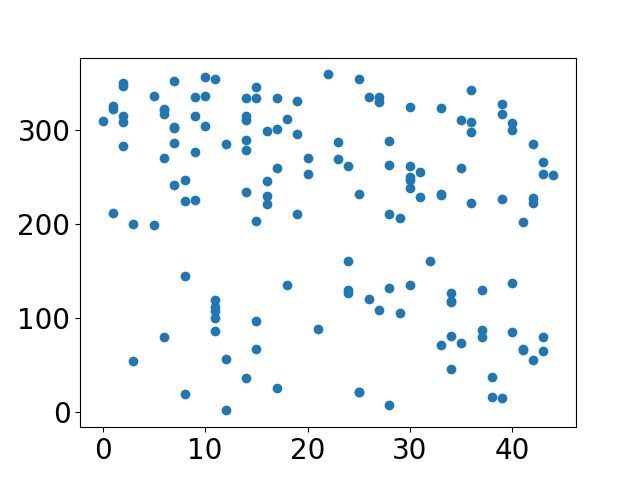

In [21]:
total_corrections = np.ma.masked_invalid(total_corrections_copy.copy())
n_corrections = total_corrections.shape[0]
fig, ax = plt.subplots()
for plane in range(n_corrections):
    ax.scatter(np.arange(45), total_corrections[plane, :]%360, c='tab:blue')

averaged_corrections = []
median_corrections = []
stdev_corrections = []

# calculate the mean/median etc. 
for baseline in range(45): # total_corrections already has the planes selected from above
    median = angular_median(np.deg2rad(total_corrections[:, baseline]%360))
    mean, stdev = angular_mean_and_stdev(np.deg2rad(total_corrections[:, baseline]))
    averaged_corrections.append(np.rad2deg(mean))
    median_corrections.append(np.rad2deg(median))
    stdev_corrections.append(np.rad2deg(stdev))

averaged_corrections = np.array(averaged_corrections)
averaged_corrections[averaged_corrections < 0] += 360

median_corrections = np.array(median_corrections)
stdev_corrections = np.array(stdev_corrections)

averaged_corrections_old = averaged_corrections.copy()
median_corrections_old = median_corrections.copy()
stdev_corrections_old = stdev_corrections.copy()

ax.scatter(np.arange(45), averaged_corrections, c='red', label='angular mean')
ax.scatter(np.arange(45), median_corrections, c='yellow', label='angular median')
ax.scatter(np.arange(45), stdev_corrections, c='green', label='angular standard dev')
ax.legend()
ax.set_title('Before Data Filter')
ax.grid()
plt.show()


# ---------------------------------------------------------------------

# now, do it again but exclude outlier points based on the median
difference_from_median_to_exclude = 30
outliers = np.zeros(total_corrections.shape, dtype=np.bool)
for baseline in range(45):
    difference1 = np.abs(total_corrections[:, baseline]%360 - median_corrections[baseline])
    difference2 = np.abs(total_corrections[:, baseline]%360 - median_corrections[baseline] + 360)
    difference3 = np.abs(total_corrections[:, baseline]%360 - median_corrections[baseline] - 360)
    outlier = np.fmin(np.fmin(difference1, difference2), difference3) > difference_from_median_to_exclude
    outliers[outlier, baseline] = True

fig, ax = plt.subplots()
for plane in range(n_corrections):
    not_outliers = ~outliers[plane, :]
    ax.scatter(np.arange(45)[not_outliers], total_corrections[plane, not_outliers]%360, c='tab:blue')

averaged_corrections = []
median_corrections = []
stdev_corrections = []

for baseline in range(total_corrections.shape[1]): # total_corrections already has the planes selected from above
    not_outliers = ~outliers[:, baseline]
    #print(not_outliers)
    #if not_outliers.shape == total_corrections[:, baseline].shape:
    #    print(f'no outliers baseline {baseline}')
        
    print(f'baseline {baseline}: {np.count_nonzero(not_outliers)} points included')
    
    try:
        median = angular_median(np.deg2rad(total_corrections[not_outliers, baseline]%360))
    except:
        print(f'not enough points on baseline {baseline}, increase data filter tolerance')
        median = np.deg2rad(np.rad2deg(total_corrections[not_outliers, baseline][0])%360)

    mean, stdev = angular_mean_and_stdev(np.deg2rad(total_corrections[not_outliers, baseline]))
    averaged_corrections.append(np.rad2deg(mean))
    median_corrections.append(np.rad2deg(median)%360)
    stdev_corrections.append(np.rad2deg(stdev))


averaged_corrections = np.array(averaged_corrections)
averaged_corrections[averaged_corrections < 0] += 360

median_corrections = np.array(median_corrections)
stdev_corrections = np.array(stdev_corrections)

ax.scatter(np.arange(45), averaged_corrections, c='red', label='angular mean')
ax.scatter(np.arange(45), median_corrections, c='yellow', label='angular median')
ax.scatter(np.arange(45), stdev_corrections, c='green', label='angular standard dev')
ax.legend()
ax.set_title('After Data Filter')
ax.grid()

plt.show()

print(np.rad2deg(median_corrections)%360)
print(np.rad2deg(median_corrections_old)%360)

In [12]:
np.save(f'median_corrections_{year:04d}-{month:02d}-{day:02d}.npy', median_corrections)

In [ ]:
# Level 2 data will now have to be processed before continuing

In [8]:
# inputs to the second part of the script:
# level2_files - the result of processing the uncalibrated level 1 data to level 2 data using the baseline calibrations
#                found in the previous cell. 

level2_files = []
#level2_files.append(f'/mnt/NAS/airplane-data/L2_1/{year}/{month:02d}/{year}_{month:02d}_{(day):02d}/ib3d_normal_swht_{year}_{month:02d}_{(day):02d}_prelate_bakker.h5') # without relaxation

#level2_files.append(f'/mnt/NAS/airplane-data/L2-Scal/{year}/{month:02d}/{year}_{month:02d}_{(day):02d}/ib3d_normal_swht_{year}_{month:02d}_{(day):02d}_prelate_bakker.h5') # non airplane calibrated
level2_files.append(f'/mnt/NAS/airplane-data/L2-standardcal/{year}/{month:02d}/{year}_{month:02d}_{(day):02d}/ib3d_normal_swht_{year}_{month:02d}_{(day):02d}_prelate_bakker.h5') # non airplane calibrated
#level2_files.append(f'/mnt/NAS/airplane-data/L2-new-coeffs-with-cal-and-pos-azimuth-median_1/{year}/{month:02d}/{year}_{month:02d}_{(day):02d}/ib3d_normal_swht_{year}_{month:02d}_{(day):02d}_prelate_bakker.h5') # non airplane calibrated

#level2_files.append(f'/mnt/NAS/airplane-data/L2-median-calibrated/{year}/{month:02d}/{year}_{month:02d}_{(day):02d}/ib3d_normal_swht_{year}_{month:02d}_{(day):02d}_prelate_bakker.h5') # non airplane calibrated


/mnt/NAS/airplane-data/L2-standardcal/2021/03/2021_03_20/ib3d_normal_swht_2021_03_20_prelate_bakker.h5


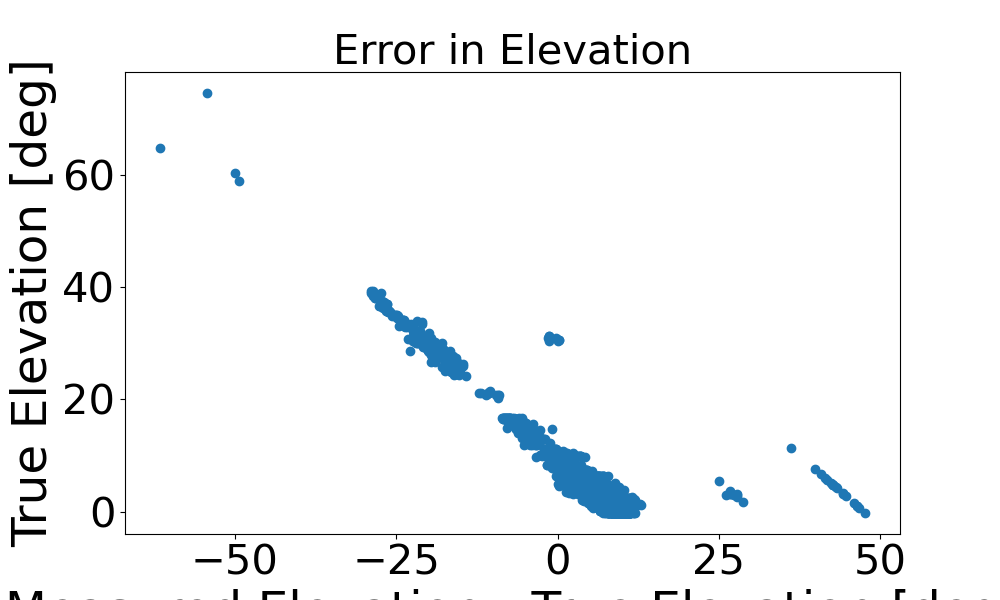

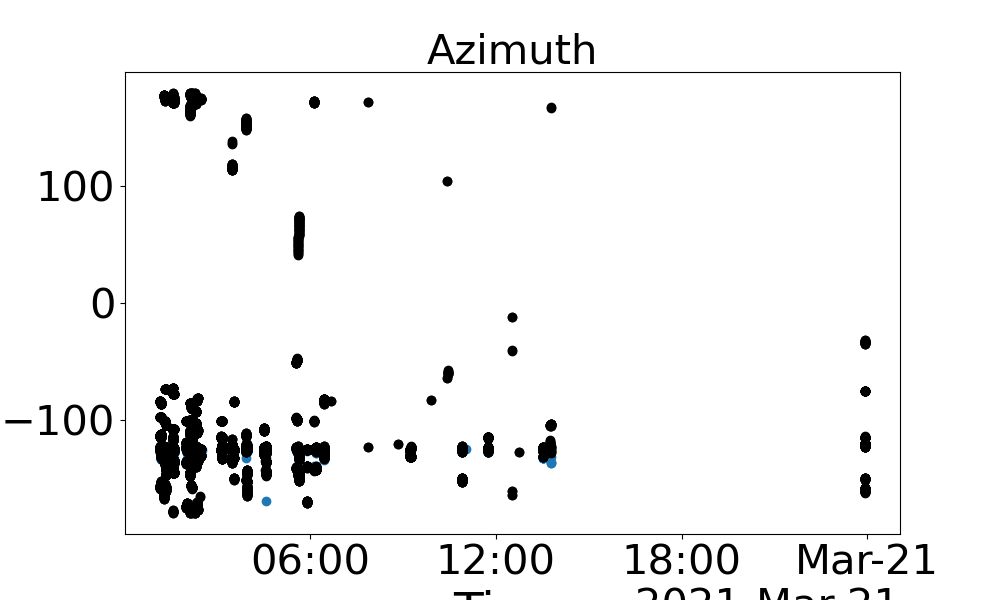

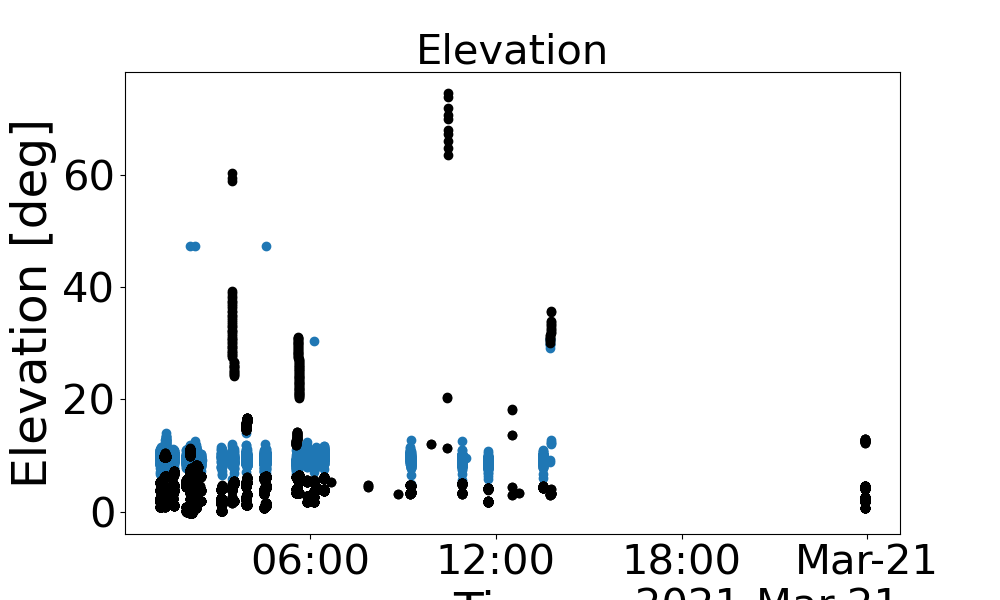

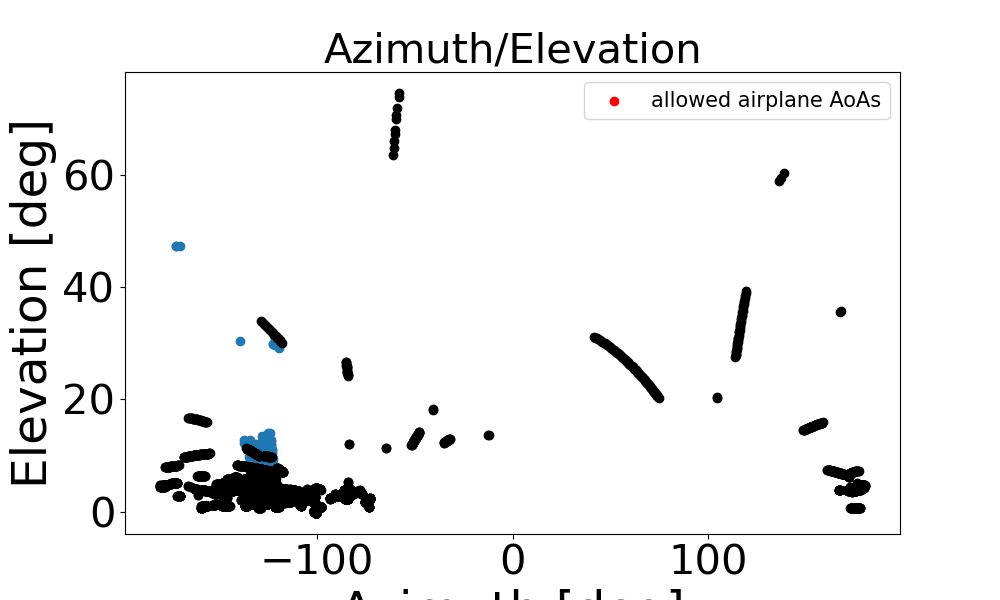

In [166]:
# plot up the level 2 data and the corresponding airplane data
fig_az, ax_az = plt.subplots()
fig_az.set_size_inches(fig_width_inches, fig_height_inches)
ax_az.set_ylabel('Azimuth [deg]')
ax_az.set_xlabel('Time')
ax_az.set_title(f'Azimuth')
ax_az.xaxis.set_major_locator(locator)
ax_az.xaxis.set_major_formatter(formatter)

fig_el, ax_el = plt.subplots()
fig_el.set_size_inches(fig_width_inches, fig_height_inches)
ax_el.set_ylabel('Elevation [deg]')
ax_el.set_xlabel('Time')
ax_el.set_title(f'Elevation')
ax_el.xaxis.set_major_locator(locator)
ax_el.xaxis.set_major_formatter(formatter)

fig_azel, ax_azel = plt.subplots()
fig_azel.set_size_inches(fig_width_inches, fig_height_inches)
ax_azel.set_ylabel('Elevation [deg]')
ax_azel.set_xlabel('Azimuth [deg]')
ax_azel.set_title(f'Azimuth/Elevation')
# plot the allowed az/el polygon (wrt boresight)
az = np.load('allowed_airplane_azimuth.npy')
az = np.where(az > 180.0, az - 360.0, az)
el = np.load('allowed_airplane_elevation.npy')
ax_azel.scatter(az, el, c='red')
ax_azel.legend(['allowed airplane AoAs'])

fig_els, ax_els = plt.subplots()
fig_els.set_size_inches(fig_width_inches, fig_height_inches)
ax_els.set_ylabel('True Elevation [deg]')
ax_els.set_xlabel('Measured Elevation - True Elevation [deg]')
ax_els.set_title(f'Error in Elevation')

for file in level2_files:
    print(file)
    try:
        f = h5py.File(file)
    except Exception as e:
        print(f'Excepted {e}\nContinuing...')
        continue
    altitude = f['data']['altitude'][:]
    azimuth = f['data']['azimuth'][:]
    doppler_shift = f['data']['doppler_shift'][:]
    elevation = f['data']['elevation'][:]
    latitude = f['data']['latitude'][:]
    longitude = f['data']['longitude'][:]
    rf_distance = f['data']['rf_distance'][:]
    slant_range = f['data']['slant_range'][:]
    snr_db = f['data']['snr_db'][:]
    time = f['data']['time'][:]
    utc_time = vutcfromtimestamp(time)

    #range_filter = (rf_distance < 256) & (rf_distance > 246)
    #else:
    #range_filter = (rf_distance < 301) & (rf_distance > 291)
    range_filter = (rf_distance < 301) & (rf_distance > 246)
        
    # plot az and el / time
    ax_az.scatter(utc_time[range_filter], azimuth[range_filter])
    ax_el.scatter(utc_time[range_filter], elevation[range_filter])
    
    # plot az/el
    ax_azel.scatter(azimuth[range_filter], elevation[range_filter])
    
    f.close()

aircrafts_dbs = ap.load_airplane_data(f'aircrafts_dbs_{year:04d}-{month:02d}-{day:02d}.pckl')
plane_indices = [1,3,9,12,16,34,53,67,106,109,123,127,132,139,141,143,150,152,182] # 12/12/2020
plane_indices = []
airplane_idx = 0

el_difference = []
true_el = []
for db in aircrafts_dbs:
    # db is a database of every airplane in the timeframe.
    if db == None:
        continue
        
    # db[i].data.long/lat is the time series of data for one airplane (i)
    
    for i in range(len(db)): # db[i] is a single airplane in the timeframe.

        if airplane_idx not in plane_indices:
            plane_indices.append(airplane_idx)
            airplane_idx += 1
            #continue

        # indexes in db continue multiple airplanes, so need to manually find the indices for this airplane
        start_idx = db[i].data.index[0]
        end_idx = db[i].data.index[-1]

        # using the indexes, find the start and end times of the airplane
        ti = db[i].data.timestamp[start_idx]
        ti = ti.replace(tzinfo=None)
        tf = db[i].data.timestamp[end_idx]
        tf = tf.replace(tzinfo=None)

        
        # from the airplane's geographic latitude/longitude/altitude, find the azimuth/elevation/altitude of the airplane from the receiver
        # this azimuth is measured EAST OF NORTH
        az, el, slant_range = ap.find_aer_from_receiver(db[i].data.latitude, db[i].data.longitude, db[i].data.altitude * FT_TO_M)
        # still east of north, but adjusted to be -180 to 180 instead of 0 to 360
        az = np.where(az > 180.0, az - 360.0, az)

        this_airplane_db_time = db[i].data.timestamp[:] # .to_pydatetime().replace(tzinfo=timezone.utc)

        # level 2 data filtered by time
        for k in range(this_airplane_db_time.shape[0]):
            index = this_airplane_db_time.index[k]
            l2_el = elevation[utc_time == this_airplane_db_time[index].to_pydatetime().replace(tzinfo=None)]
            el_difference.append(l2_el - el[index])
            for m in range(l2_el.shape[0]):
                true_el.append(el[index])
            
        # plot az and el
        ax_el.scatter(this_airplane_db_time, el, c='black')
        ax_az.scatter(this_airplane_db_time, az, c='black')
        ax_azel.scatter(az, el, c='black')

        airplane_idx += 1

true_el = np.hstack(true_el)
el_difference = np.hstack(el_difference)

#ax_els.hist(el_difference, bins=[-6+i*0.2 for i in range(50)])
ax_els.scatter(el_difference, true_el)

plt.show()


/mnt/NAS/airplane-data/L2-standardcal/2020/12/2020_12_14/ib3d_normal_swht_2020_12_14_prelate_bakker.h5


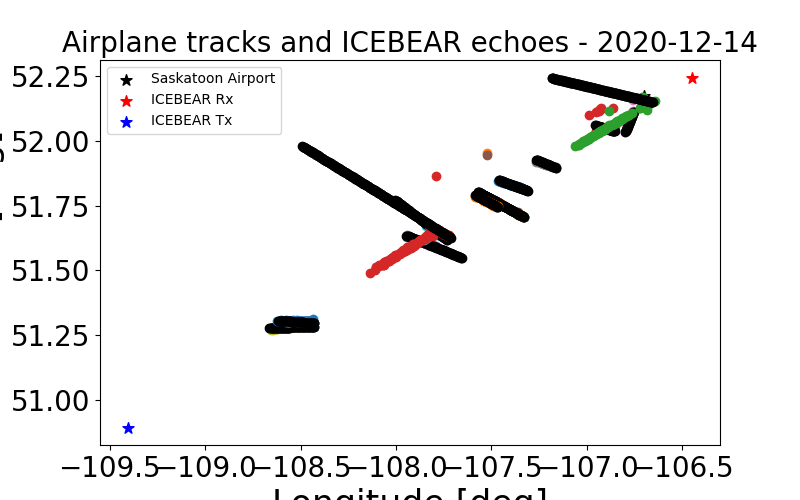

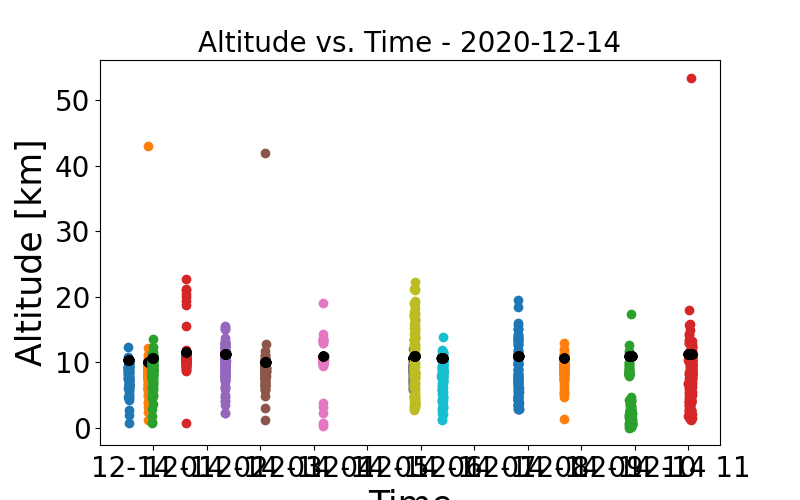

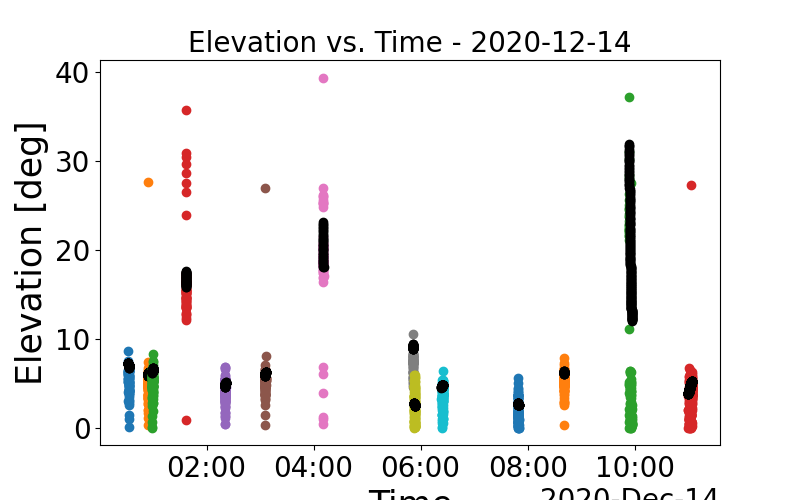

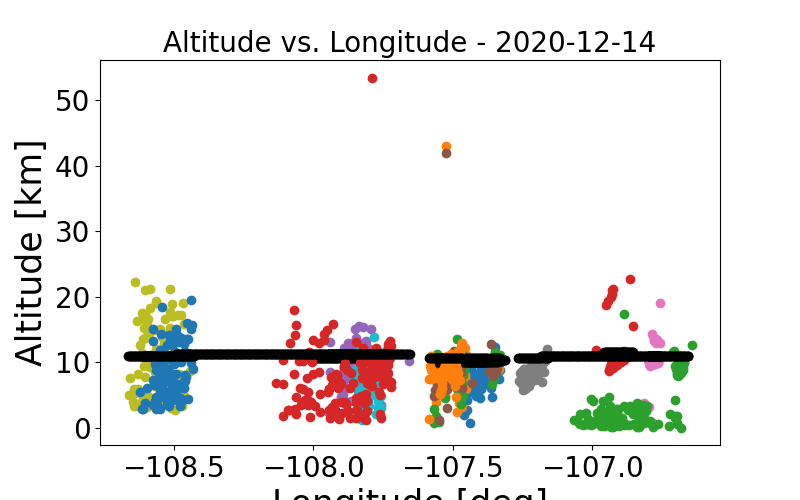

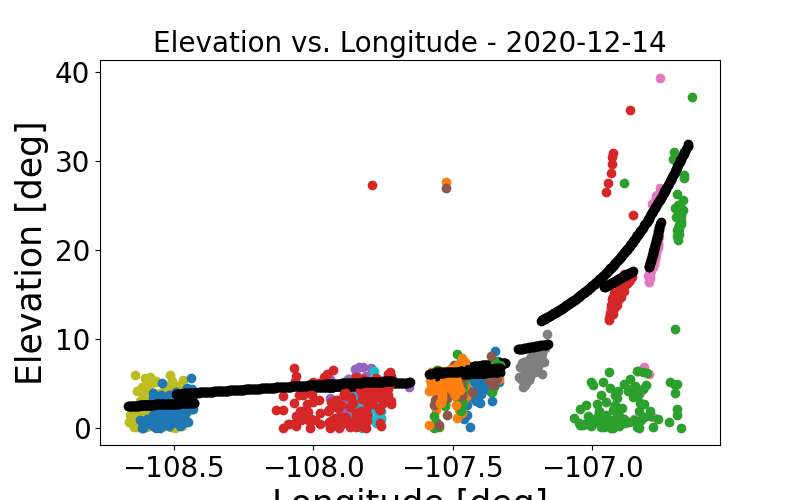

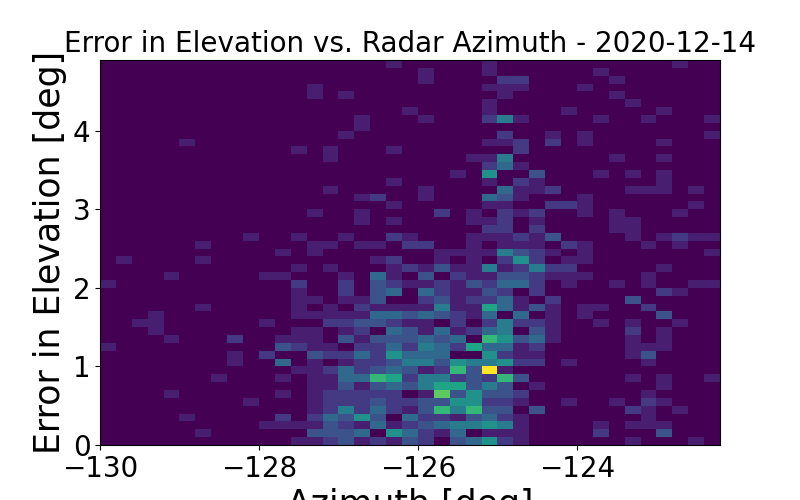

In [9]:
# perform manual geolocation of the echoes using AoA
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)

fig_ll, ax_ll = plt.subplots()
fig_ll.set_size_inches(fig_width_inches, fig_height_inches)
ax_ll.set_ylabel('Latitude [deg]')
ax_ll.set_xlabel('Longitude [deg]')
ax_ll.set_title(f'Airplane tracks and ICEBEAR echoes - {year:04}-{month:02d}-{day:02d}')
stoon_airport = [52.17145, -106.70039]
icebear_rx = [52.24393, -106.45025]
icebear_tx = [50.89335, -109.40317]
ax_ll.scatter(stoon_airport[1], stoon_airport[0], marker='*', c='black', s=70)
ax_ll.scatter(icebear_rx[1], icebear_rx[0], marker='*', c='r', s=70)
ax_ll.scatter(icebear_tx[1], icebear_tx[0], marker='*', c='b', s=70)
#ax_ll.set_xlim([-109.8, -105.8])
#ax_ll.set_ylim([50, 53])
ax_ll.legend(['Saskatoon Airport','ICEBEAR Rx','ICEBEAR Tx'])

fig_alt, ax_alt = plt.subplots()
fig_alt.set_size_inches(fig_width_inches, fig_height_inches)
ax_alt.set_ylabel('Altitude [km]')
ax_alt.set_xlabel('Time')
ax_alt.set_title(f'Altitude vs. Time - {year:04}-{month:02d}-{day:02d}')
#ax_lon_alt.xaxis.set_major_locator(locator)
#ax_lon_alt.xaxis.set_major_formatter(formatter)

fig_el, ax_el = plt.subplots()
fig_el.set_size_inches(fig_width_inches, fig_height_inches)
ax_el.set_ylabel('Elevation [deg]')
ax_el.set_xlabel('Time')
ax_el.set_title(f'Elevation vs. Time - {year:04}-{month:02d}-{day:02d}')
ax_el.xaxis.set_major_locator(locator)
ax_el.xaxis.set_major_formatter(formatter)

fig_lon_alt, ax_lon_alt = plt.subplots()
fig_lon_alt.set_size_inches(fig_width_inches, fig_height_inches)
ax_lon_alt.set_ylabel('Altitude [km]')
ax_lon_alt.set_xlabel('Longitude [deg]')
ax_lon_alt.set_title(f'Altitude vs. Longitude - {year:04}-{month:02d}-{day:02d}')
#ax_lon_alt.xaxis.set_major_locator(locator)
#ax_lon_alt.xaxis.set_major_formatter(formatter)

fig_lon_el, ax_lon_el = plt.subplots()
fig_lon_el.set_size_inches(fig_width_inches, fig_height_inches)
ax_lon_el.set_ylabel('Elevation [deg]')
ax_lon_el.set_xlabel('Longitude [deg]')
ax_lon_el.set_title(f'Elevation vs. Longitude - {year:04}-{month:02d}-{day:02d}')
#ax_lon_el.xaxis.set_major_locator(locator)
#ax_lon_el.xaxis.set_major_formatter(formatter)

fig_errel, ax_errel = plt.subplots()
fig_errel.set_size_inches(fig_width_inches, fig_height_inches)
ax_errel.set_ylabel('Error in Elevation [deg]')
ax_errel.set_xlabel('Azimuth [deg]')
ax_errel.set_title(f'Error in Elevation vs. Radar Azimuth - {year:04}-{month:02d}-{day:02d}')
#ax_lon_el.xaxis.set_major_locator(locator)
#ax_lon_el.xaxis.set_major_formatter(formatter)

for file in level2_files:
    print(file)
    try:
        f = h5py.File(file)
    except Exception as e:
        print(f'Excepted {e}\nContinuing...')
        continue
    altitude = f['data']['altitude'][:]
    azimuth = f['data']['azimuth'][:]
    doppler_shift = f['data']['doppler_shift'][:]
    elevation = f['data']['elevation'][:]
    latitude = f['data']['latitude'][:]
    longitude = f['data']['longitude'][:]
    rf_distance = f['data']['rf_distance'][:]
    slant_range = f['data']['slant_range'][:]
    snr_db = f['data']['snr_db'][:]
    time = f['data']['time'][:]
    utc_time = vutcfromtimestamp(time)
    echo_timestamps = ap.datetime_to_seconds_since_epoch(utc_time)
    

    range_filter = (rf_distance < 256) & (rf_distance > 246)
    #range_filter = (rf_distance < 301) & (rf_distance > 291)

    # calculate the slant range from ICEBEAR data
    # rho_rf = (rf_distance[range_filter] - 45) * 1.0e3
    # find_kappa(rho_rf, azimuth, elevation, range_filter)
    
    
    # # calculate slant range
    # print(rho_rf[0:10])
    # print(rho_d)
    # print(cos_kappa)
    # slant_range = (rho_rf ** 2 - rho_d ** 2) / (2 * (rho_rf - rho_d * cos_kappa))
    # print(slant_range)

    # # from slant range and az/el, map the target in lat/lon/alt
    # lat, lon, alt = pm.aer2geodetic(azimuth[range_filter], elevation[range_filter], slant_range,
    #                           np.repeat(RX[0], azimuth[range_filter].shape[0]),
    #                           np.repeat(RX[1], azimuth[range_filter].shape[0]),
    #                           np.repeat(RX[2], azimuth[range_filter].shape[0]),
    #                           ell=pm.Ellipsoid.from_name("wgs84"), deg=True)
            

    
    # also load in the aircraft data for this day
    aircrafts_dbs = ap.load_airplane_data(f'aircrafts_dbs_{year:04d}-{month:02d}-{day:02d}.pckl')
            
    elevation_error = []
    azimuths_to_plot = []
    
    # now, loop through all airplanes in this day, and for each valid airplane, find kappa using the airplanes true dist from receiver
    airplane_idx = 0
    for db in aircrafts_dbs:
        # db is a database of every airplane in the timeframe.
        if db == None:
            continue
            
        # db[i].data.long/lat is the time series of data for one airplane (i)
        
        for i in range(len(db)): # db[i] is a single airplane in the timeframe.
    
            # indexes in db continue multiple airplanes, so need to manually find the indices for this airplane
            start_idx = db[i].data.index[0]
            end_idx = db[i].data.index[-1]
    
            # using the indexes, find the start and end times of the airplane
            ti = db[i].data.timestamp[start_idx]
            ti = ti.replace(tzinfo=None)
            tf = db[i].data.timestamp[end_idx]
            tf = tf.replace(tzinfo=None)
            
            # we don't want to look at the short airplanes
            if end_idx - start_idx <= 6:
                airplane_idx += 1
                continue
    
            # or the short airplanes
            if np.mean(db[i].data.altitude * FT_TO_M) < 5000:
                airplane_idx += 1
                continue
            
            # from the airplane's geographic latitude/longitude/altitude, find the azimuth/elevation/altitude of the airplane from the receiver
            # this azimuth is measured EAST OF NORTH
            az, el, slant_range = ap.find_aer_from_receiver(db[i].data.latitude, db[i].data.longitude, db[i].data.altitude * FT_TO_M)
            # still east of north, but adjusted to be -180 to 180 instead of 0 to 360
            az = np.where(az > 180.0, az - 360.0, az)
            az = -az + 90 # convert to NORTH OF East angles
    
            # narrow the geographic bounds
            if np.any(db[i].data.latitude > 52.25) \
                or np.any(db[i].data.longitude > -106.5) \
                or np.any(db[i].data.longitude < -109.0) \
                or np.all(el > 25) \
                or np.all(90 - az < -128) \
                or np.all(90 - az > -122):
                #or np.all(az < 180)
                #or np.all(az > 270)
            
                airplane_idx += 1
                continue
    
            this_airplane_db_time = db[i].data.timestamp[:] # .to_pydatetime().replace(tzinfo=timezone.utc)
            this_airplane_db_timestamps = ap.datetime_to_seconds_since_epoch(this_airplane_db_time.dt.to_pydatetime())

            repeated_slant_range = []
            overall_time_filter = np.zeros(time.shape)
            for k in range(this_airplane_db_time.shape[0]):
                idx = db[i].data.index[k]
                time_filter = time * 1.0 == this_airplane_db_timestamps[k]
                repeated_slant_range.append(np.repeat(slant_range[idx], azimuth[time_filter].shape[0]))
                overall_time_filter = np.logical_or(overall_time_filter, time_filter)
                

                elevation_error.append(np.abs(el[idx] - elevation[time_filter]))
                azimuths_to_plot.append(azimuth[time_filter])


            repeated_slant_range = np.hstack(repeated_slant_range)
            time_filter = (range_filter) & (overall_time_filter)

            # from slant range and az/el, map the target in lat/lon/alt
            lat, lon, alt = pm.aer2geodetic(azimuth[time_filter], elevation[time_filter], repeated_slant_range,
                                       np.repeat(RX[0], azimuth[time_filter].shape[0]),
                                       np.repeat(RX[1], azimuth[time_filter].shape[0]),
                                       np.repeat(RX[2], azimuth[time_filter].shape[0]),
                                       ell=pm.Ellipsoid.from_name("wgs84"), deg=True)
            
            # plot lat/lon
            ax_ll.scatter(lon, lat)
            ax_ll.scatter(db[i].data.longitude, db[i].data.latitude, c='black')

            # altitude time
            ax_alt.scatter(utc_time[time_filter], alt/1000)
            ax_alt.scatter(this_airplane_db_time, db[i].data.altitude * FT_TO_M / 1000, c='black')
            
            # elevation time
            ax_el.scatter(utc_time[time_filter], elevation[time_filter])
            ax_el.scatter(this_airplane_db_time, el, c='black')

            # altitude longitude
            ax_lon_alt.scatter(lon, alt/1000)
            ax_lon_alt.scatter(db[i].data.longitude, db[i].data.altitude * FT_TO_M / 1000, c='black')

            # elevation longitude
            ax_lon_el.scatter(lon, elevation[time_filter])
            ax_lon_el.scatter(db[i].data.longitude, el, c='black')

            # elevation error azimuth
            #ax_errel.scatter(azimuths_to_plot, elevation_error)
            
            # altitude azimuth
            #ax_alt.scatter(azimuth[time_filter], alt/1000)
            #ax_alt.scatter(90-az, db[i].data.altitude * FT_TO_M / 1000, c='black')
            
            #ax_alt.scatter(azimuth[time_filter], alt/1000)
            airplane_idx += 1

    elevation_error = np.hstack(elevation_error)
    azimuths_to_plot = np.hstack(azimuths_to_plot)
    xedges=np.arange(-130, -122, 0.2)
    yedges=np.arange(0, 5, 0.1)
    H, xedges, yedges = np.histogram2d(azimuths_to_plot, elevation_error, bins=(xedges,yedges))
    X, Y = np.meshgrid(xedges, yedges)
    ax_errel.pcolormesh(X, Y, H.T)
            

    f.close()

In [195]:
def find_kappa(rho_rf, azimuth, elevation, range_filter):
    rho_d  = (TX_RX_DISTANCE) * 1.0e3
    
    azimuth = np.where(azimuth < 0.0, azimuth + 360.0, azimuth)
    azimuth = np.deg2rad(azimuth)
    elevation = np.deg2rad(elevation)
    
    x_t, y_t, z_t = pm.geodetic2ecef(TX[0], TX[1], TX[2], ell=pm.Ellipsoid.from_name("wgs84"), deg=True) # ecef coords for transmitter
    az_rt, el_rt, range_rt = pm.ecef2aer(x_t, y_t, z_t, RX[0], RX[1], RX[2], ell=pm.Ellipsoid.from_name("wgs84"), deg=True) # vector from receiver to transmitter in az, el, range
    
    u_d = np.array([np.sin(np.deg2rad(az_rt)) * np.cos(np.deg2rad(el_rt)),
                     np.cos(np.deg2rad(az_rt)) * np.cos(np.deg2rad(el_rt)),
                     np.sin(np.deg2rad(el_rt))])
    
    u_rho = np.array([np.sin(azimuth[range_filter]) * np.cos(elevation[range_filter]),
                    np.cos(azimuth[range_filter]) * np.cos(elevation[range_filter]),
                    np.sin(elevation[range_filter])])
    
    cos_kappa = np.dot(u_rho.T, u_d)

    azimuth = np.rad2deg(azimuth)
    elevation = np.rad2deg(elevation)
    return cos_kappa